# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

## Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import gseapy as gp

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from adjustText import adjust_text
**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

In [1]:
## Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import gseapy as gp
import math


from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from adjustText import adjust_text
from scipy.stats import beta
import seaborn as sns

### Exercise 1: Simulation of circadian gene regulation

Similarly to Week 9 exercises, we first describe a system in which a (nuclear) pre-mRNA is transcribed and spliced to produce an mRNA. We can write a 2D ODE (ignoring the degradation of the pre-mRNA):

\begin{eqnarray*}
&&\frac{dP}{dt} = s(t) - \rho P \\
&&\frac{dM}{dt} = \rho P - k(t) M \\
\end{eqnarray*}

Here, $P$ and $M$ denote, respectively, the concentrations of pre-mRNA and mRNA. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is $\omega=\frac{2\pi}{T}$ with $T=24h$. $s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0 + (1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that here the peak of $s(t)$ is at $t=0$. 
Similarly, we will consider $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ is the splicing rate of pre-mRNA $P$ to mRNA $M$, and is also taken as a constant.

### Question 1
1. Adapt the code of week 9 exercises to simulate this new system. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  
2. Keep the degradation rate constant ($\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$. Discuss on how 1) the phase delay between $M(t)$ and $P(t)$ and 2) the relative amplitude of $M(t)$ varies in function of $k_0$. What is the maximal relative amplitude? Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).
3. Vary $\epsilon_k$ to include rhythmic degradation. Discuss the different effects, in particular, find situations that extend beyond what is possible with a constant half-life. See also [Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115).

## Answer 1 

#### 1. See the cell below for our code adaptation

In [2]:
def transcription_rate(s0,eps_s,t) :
    return s0*(1+ eps_s*np.cos(2*t*math.pi/(24)))

def degradation_rate(k0,eps_k,t,tk) :
    return k0*(1+ eps_k*np.cos((2*math.pi/(24))*(t-tk)))

## function definition
def func(y, t, tk, s0, k0, eps_s, eps_k, rho):
    P, M = y
    return [transcription_rate(s0,eps_s,t) - (rho) * P, rho * P - degradation_rate(k0,eps_k,t,tk) * M]


def simulation(func, par, x0 = None, t = None):
    s0=par['s0']
    k0=par['k0']
    tk = par['tk']
    eps_s=par['eps_s']
    eps_k=par['eps_k']
    rho=par['rho']

    P_ss = transcription_rate(s0,eps_s,t)/(rho) #Steady-state solution for P
    M_ss = transcription_rate(s0,eps_s,t)/degradation_rate(k0,eps_k,t,tk) #Steady-state solution for M

    
    xx=odeint(func, x0, t, args=(tk, s0, k0, eps_s, eps_k, rho))
    plt.figure(1)
    plt.ylim([0,150])
    #plt.axhline(y=np.mean(P_ss), color='r', linestyle='--') # Steady state solution mean for P_ss
    #plt.axhline(y=np.mean(M_ss), color='g', linestyle='--') # Steady state solution mean for M_ss
    plt.plot(t, xx[:,0],label = 'P(t)')
    plt.plot(t, xx[:,1],label = 'M(t)')
    plt.xlabel("time [min]")
    plt.ylabel("#molecules")
    plt.legend()
    plt.show()
    
def animate(x0, time, s0=5, k0= 0.05, eps_s=0.5, eps_k=0.5, rho=0.5, tk = 50):
    #define the function domain
    par={'s0':s0,'k0':k0, 'eps_s':eps_s, 'rho':rho,'eps_k': eps_k,'tk':tk}
    simulation(func, par, x0, time)

#initial conditions
z0=[0,0] #[P, M]
t = np.linspace(0,100,1001)
interact(animate, x0=fixed(z0), time=fixed(t), 
         s0 = (1,10,0.01), #kp^1 in [10 min, 120 min] 
         k0 = (1/360,1/10,1/1000), #km^1 in [10 min, 5000 min]
         rho = (1/30,1,0.05), #rho^1 in [1 min, 30 min]
         eps_s =(0,1,0.01),
         eps_k = (0,1,0.01),
         tk = (0,100,0.001));

interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=1.0, step=0.01), FloatSlider(valu…

### 2.a Discussion
First, we thus keep the degradation rate $\epsilon_k$=0 and we play with the $\epsilon_s$ and $k_0$ values.

By keeping $\epsilon_k$=0, the degradation rate of our mRNA is therefore only to $k_0$, which is a constant. Therefore, we can see when changing the $k_0$ value above that the quantity of mRNA in function of time, M(t) is changing a lot as well. However, P(t) does not change at all when playing with the parameters in these conditions, as it does not depend on the degradation rate.

More precisely, we can observe that increasing the $k_0$ will cause our M(t) to decrease, as it means mRNA tends to be degraded faster. In this case, our M(t) function seems to be reaching an oscillating behaviour around a mean value, which depends on the $\rho$ and $s_0$ parameters.  This will also cause the amplitude of M(t) oscillations to be larger as $k_0$ decreases.

On the other hand, decreasing $k_0$ will make M(t) grow indefinitely (or at least it seems, as our figure does not allow us to see what happens at huge values of M(t)), when decreasing $k_0$ a lot (under 0.03). M(t) will still be reduced periodically, but by a very small margin compared to the increase due to reducing $k_0$, thus inducing a general trend of increasing mRNA quantities.

### 2.b Amplitudes & phase

We can conclude that the phase delay between M(t) and P(t) does not change when varying $k_0$, as our degradation rate is a constant and does not depend on time in these conditions.

The maximum relative amplitude is thus obtained for high values of $k_0$ and, in our case, seem to be reaching a factor 2 between M(t) and P(t).

### 3. Including rythmic degradation.

Let us summarize how the different parameters change the behaviour of M(t) and P(t) now that we've included rythmic degradation in our model :

- $s_0$, $\rho$ and $\epsilon_s$ vary the general amounts of M(t) as well as of P(t). $\rho$, the splicing rate, will increase the mRNA quantities if it is high, and decrease the mRNA quantities if it is low. It thus does the opposite for P(t). Varying $s_0$ will make both M(t) and P(t) larger or smaller, as well as increasing/decreasing the oscillations amplitude in the same way. $\epsilon_s$, the transcription rate, will only increase or decrease the oscillations, as for a $\epsilon_s$ = 0 for instance, the transcription will be constant and no oscillations will thus appear on our graph


- $\epsilon_k$ : Only has an effect on M(t), as previously said. Large values of $\epsilon_k$ increase the M(t) oscillations amplitude (if $k_0$ is large enough), while small values of $\epsilon_k$ do the opposite. Also acts with $t_k$ to change the phase delay between P(t) and M(t)(the phase delay will change more or less with for different values of $\epsilon_k$ depending on $t_k$, see below )


- $k_0$ : Same effects as in the discussion above.


- $t_k$ : Will affect the phase delay between M(t) and P(t) by acting on the rythmic degradation rate k(t). When all other values are set and $k_0$ is high enough, varying $t_k$ will thus modify the behaviour of the M(t) oscillations, by varying their amplitude as well as the phase delay with P(t). 

### find situations that extend beyond what is possible with a constant half-life?

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

We will now analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12h-12h light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1
1. Adapt code from week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes): ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``. First start with only the exons, then only the introns, and eventually both. Describe your observations.
2. Using the *return_amp_phase_pv* function with the $log_2$ data, assess rhythmicity genome-wide (use the p-value to make gene selections). For the selected genes, provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough). Do this separately for the exons and introns. Do you see what's commonly referred to as the morning and evening waves of genes expression?
3. Which genes are overall the most robustly rhythmic? Is there a theme?
3. Adapting the enrichR code from Week 9 exercises, find biological function or transcriptional programs regulated rhythmically in the mouse liver. Do this separately for the night and the day. Comment.

### Answer 1 :

#### The cells below run PCA on introns, exons and then introns + exons

#### Load the RNA-seq data

In [3]:
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']

In [4]:
# get only the genes we're interested in
genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']
all_dat = dat
dat = dat.loc[genes]
i_introns = dat.columns.get_level_values('feature').isin(['Intron'])
dat_intron = dat.iloc[:,i_introns]
i_exons = dat.columns.get_level_values('feature').isin(['Exon'])
dat_exons = dat.iloc[:,i_exons]

i_all = dat.columns.get_level_values('feature').isin(['Intron', 'Exon'])
dat_tot = dat.iloc[:,i_all]

In [5]:
def run_PCA(data, nc=5, x_1=1, x_2=2, col='replicate', shape='time', scale_d=True, log=True):
    pca = PCA(n_components=nc)
    x_1=x_1-1
    x_2=x_2-1
    
    #print(data)

    if(scale_d):
        data_2 = scale(data)
        #print(data_2)
    else:
        data_2 = data

    if(log):
        data_2 =  np.log2(data_2 + 1)
  
    pca.fit(data_2.T)

    labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }


    ## compute PCA and plot
    pca_transformed = pca.transform(data_2.T)
    fig = px.scatter(pca_transformed, x=x_1, y=x_2,
                     color=data.columns.get_level_values(col),
                     symbol=data.columns.get_level_values(shape),
                     width=600, height=600)

    fig.update_traces(marker={'size': 13})
    fig.update_layout(plot_bgcolor = 'rgb(243,243,243)', xaxis_title=labels[str(x_1)],
                      yaxis_title=labels[str(x_2)])
    fig.show()

    df_pca= pd.DataFrame(pca.components_, columns=data.index, index = ['PC-1','PC-2','PC-3','PC-4','PC-5']);

    return df_pca

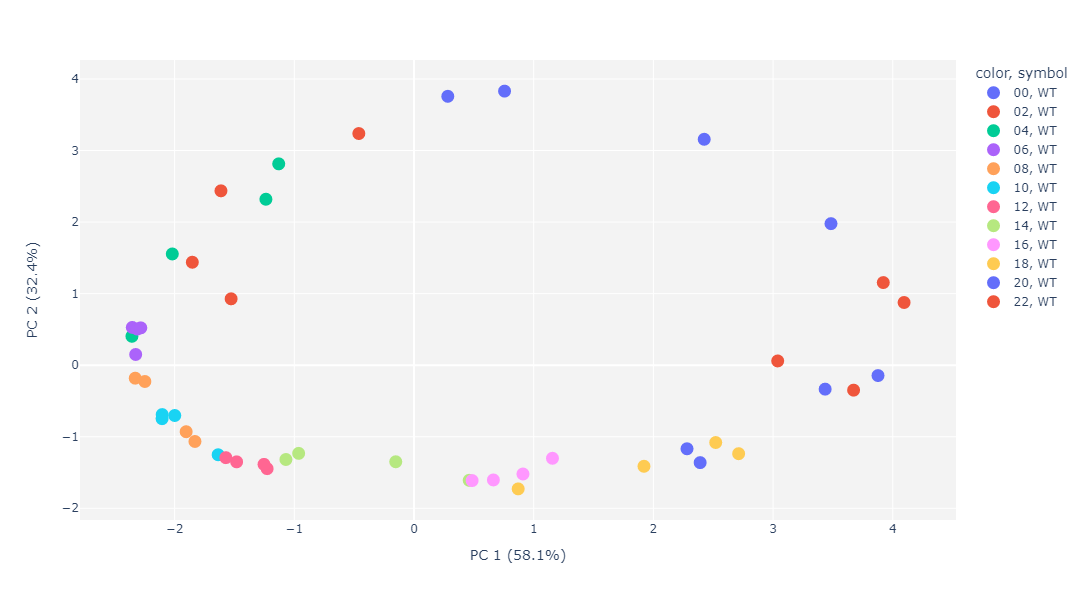

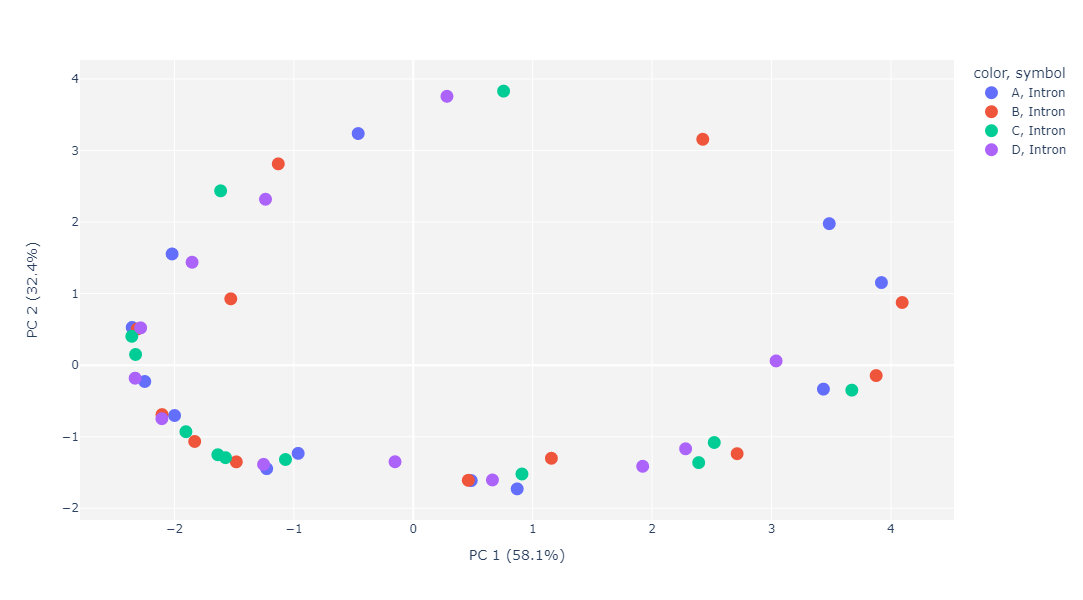

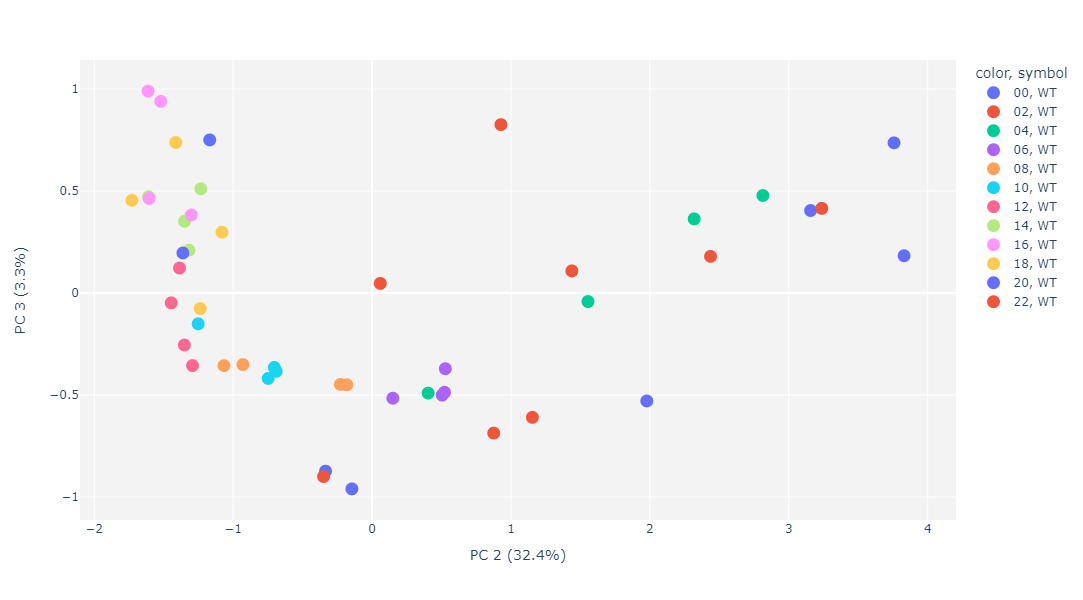

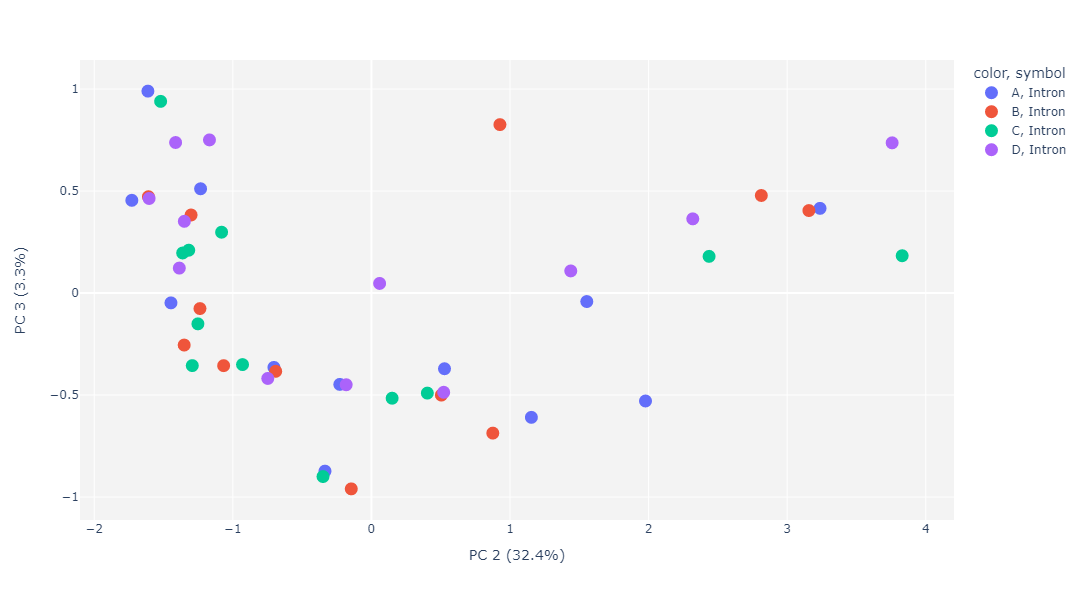

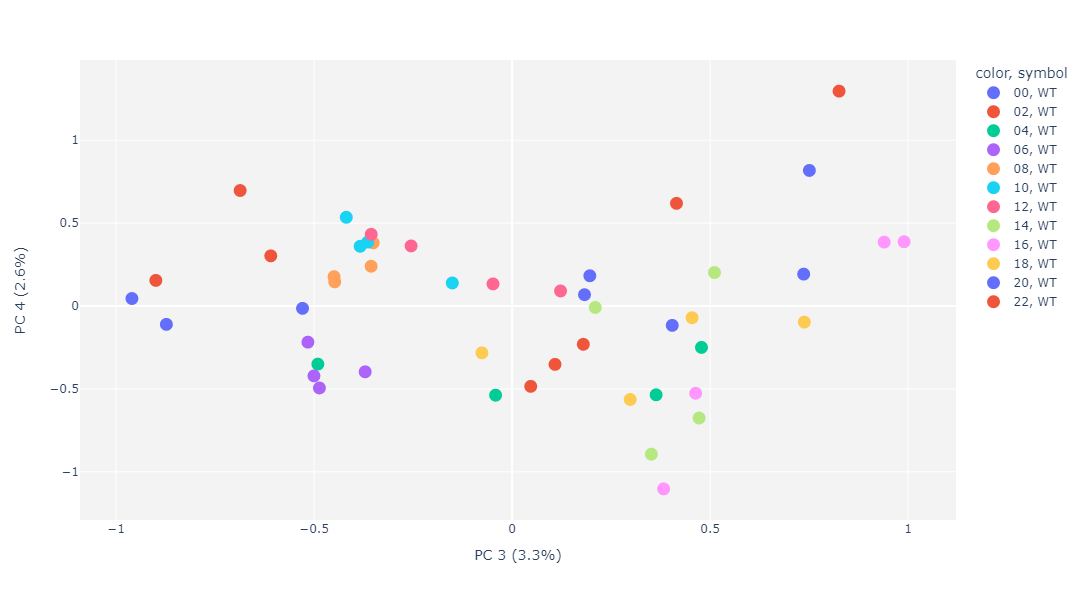

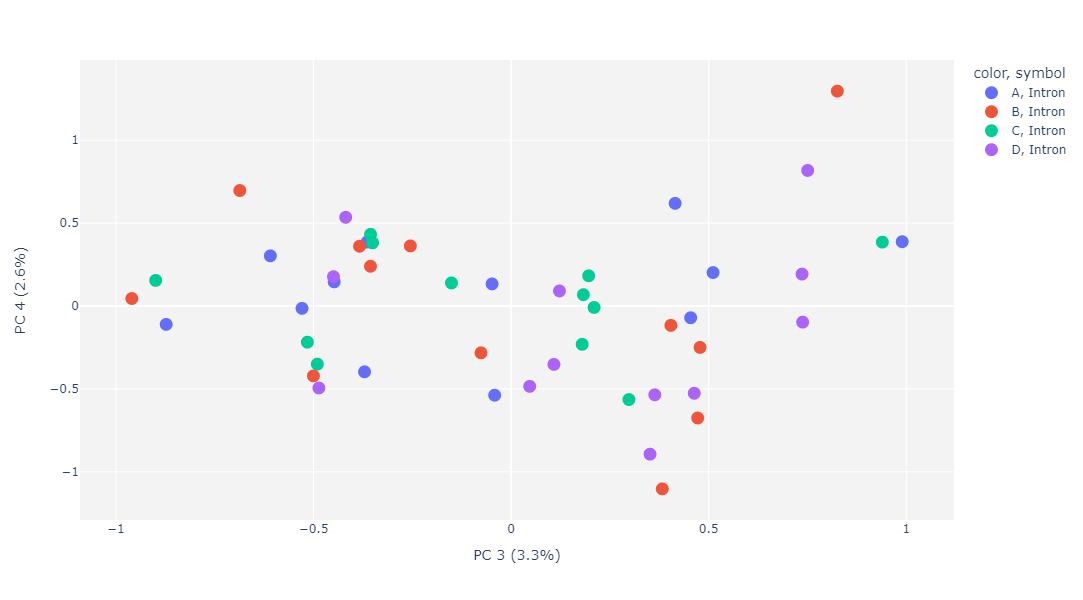

In [6]:
#Perform the PCA on introns
pca_introns = run_PCA(dat_intron, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_intron, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_intron, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

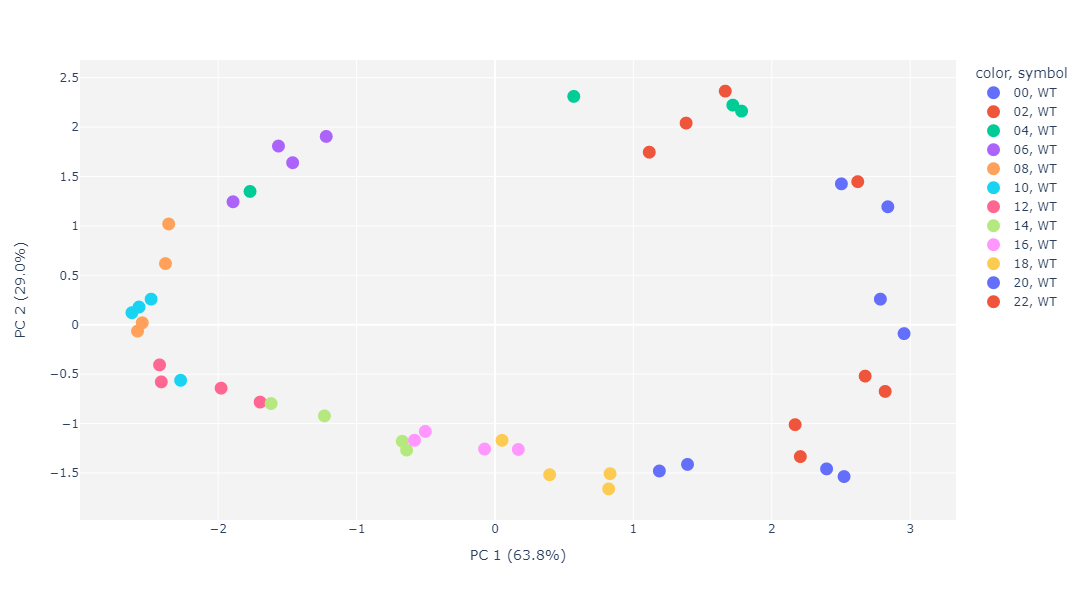

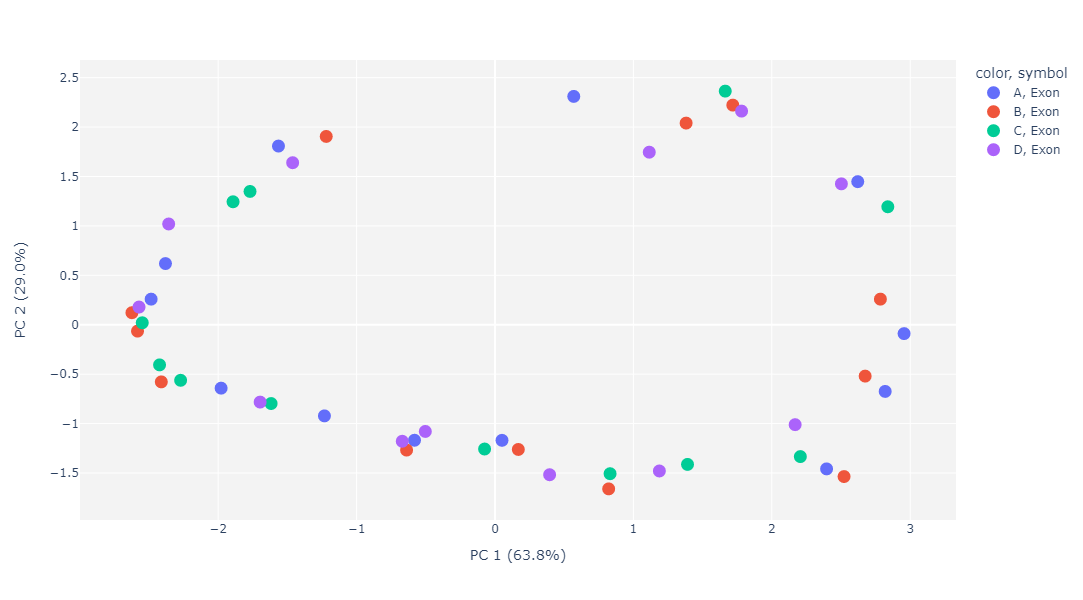

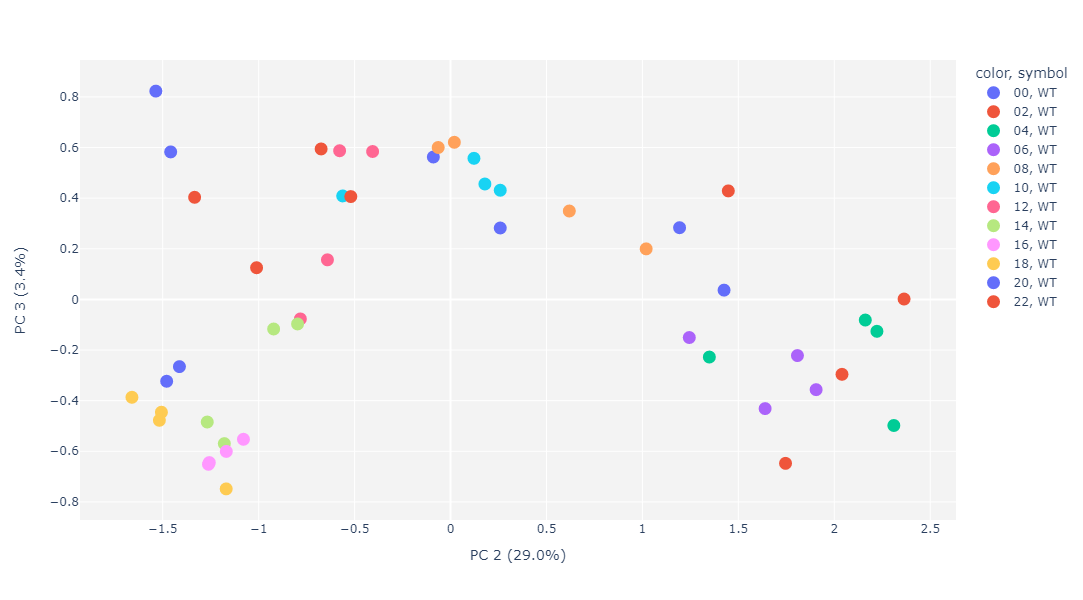

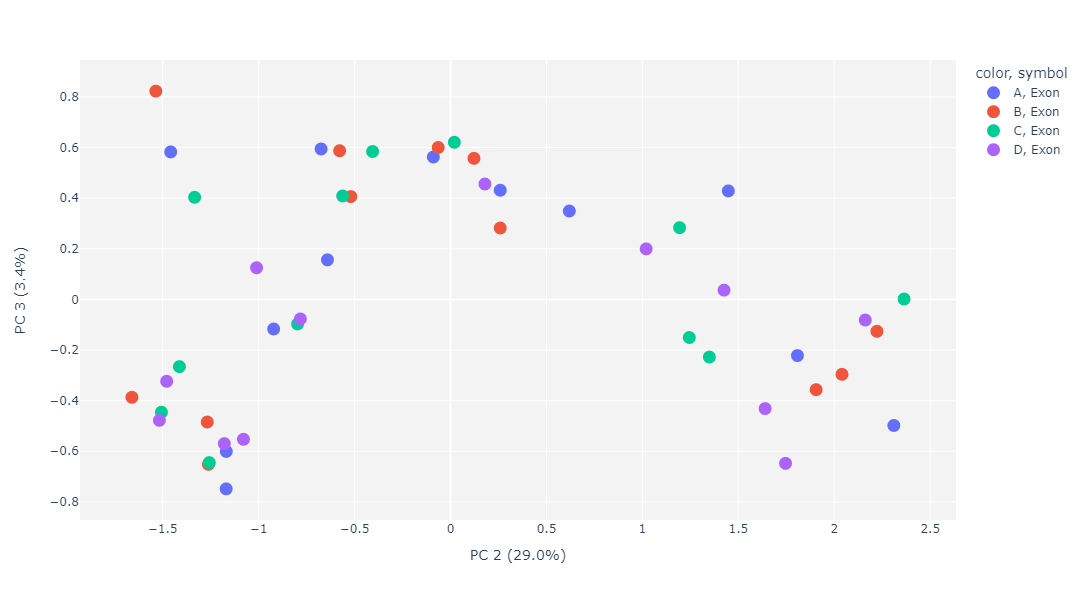

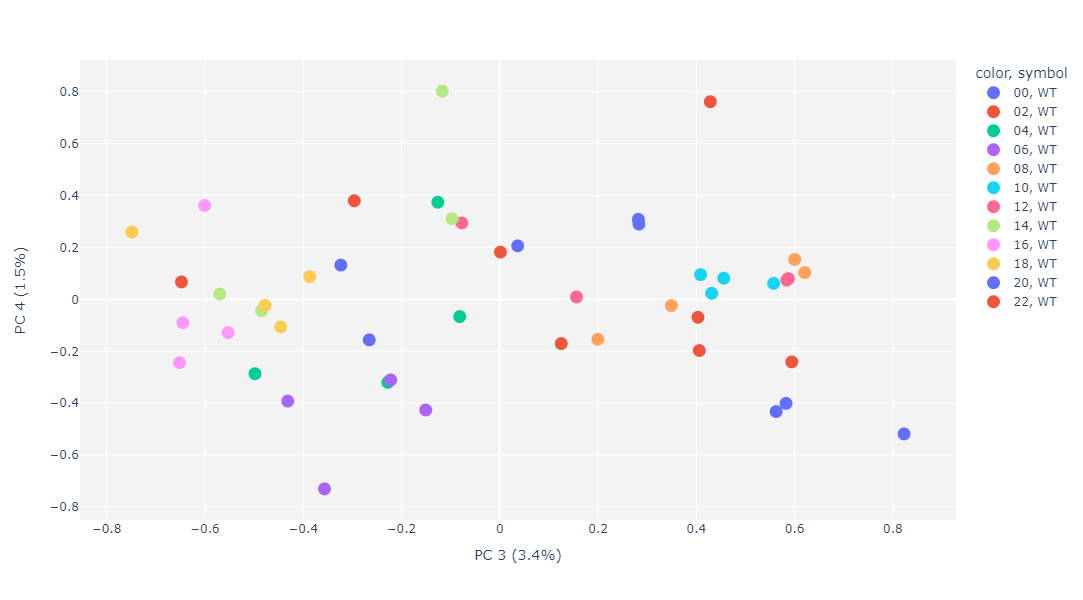

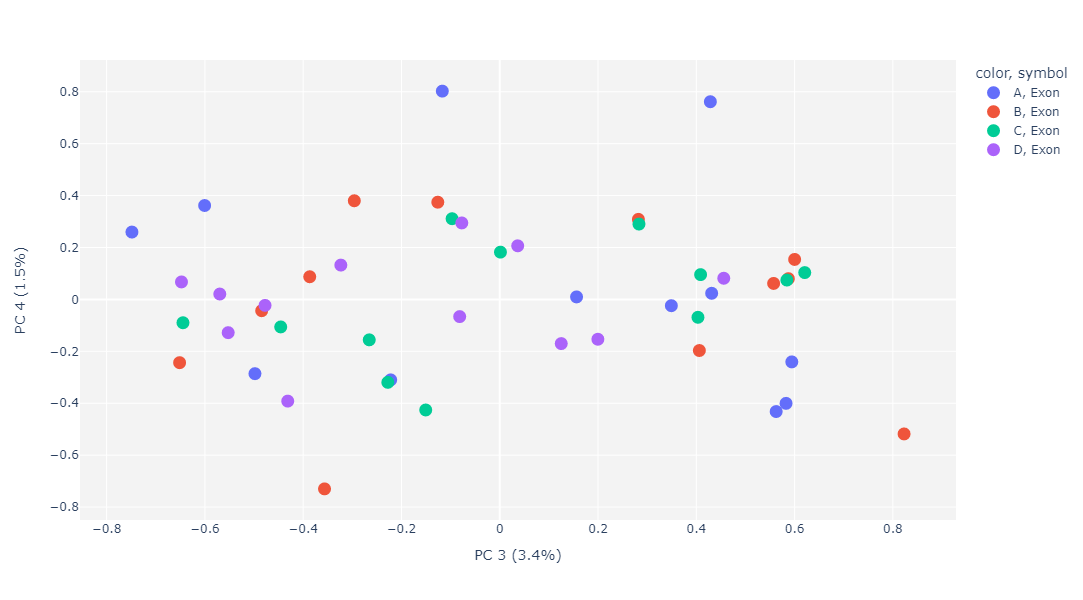

In [7]:
#Perform the PCA on exons
pca_exons = run_PCA(dat_exons, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

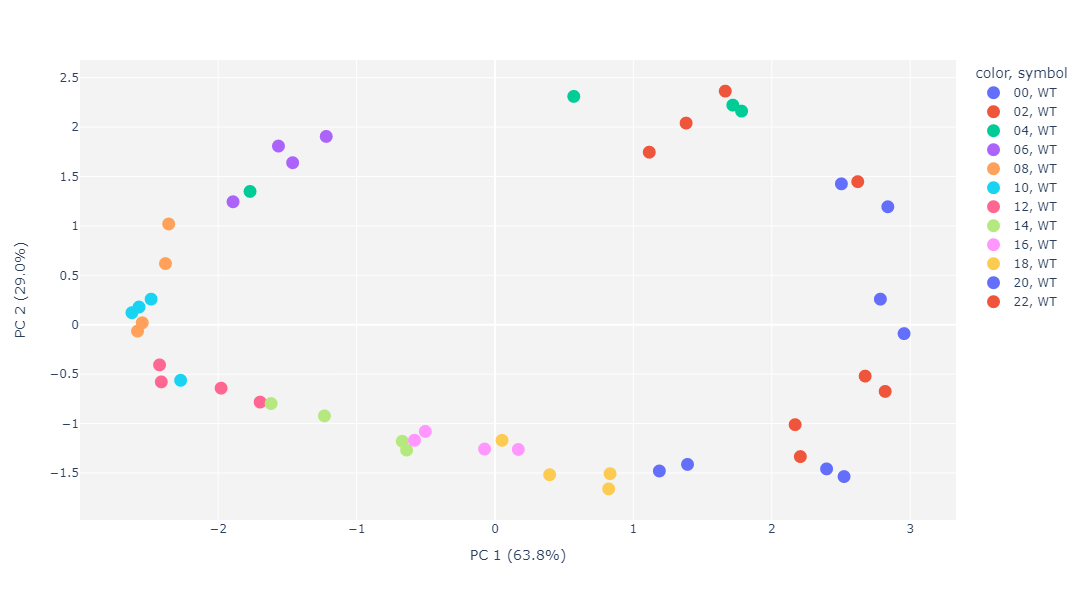

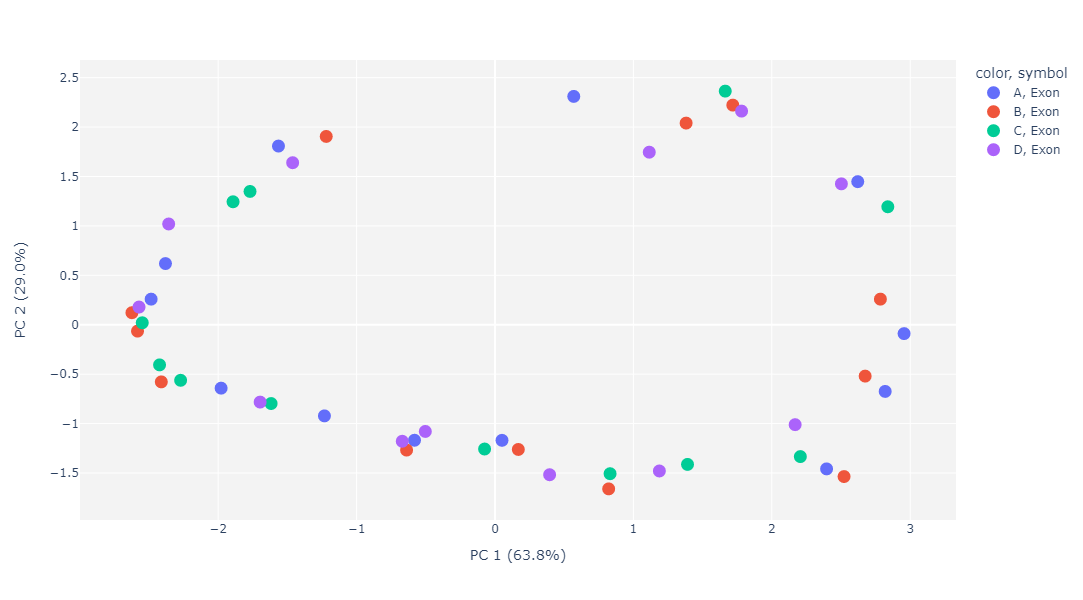

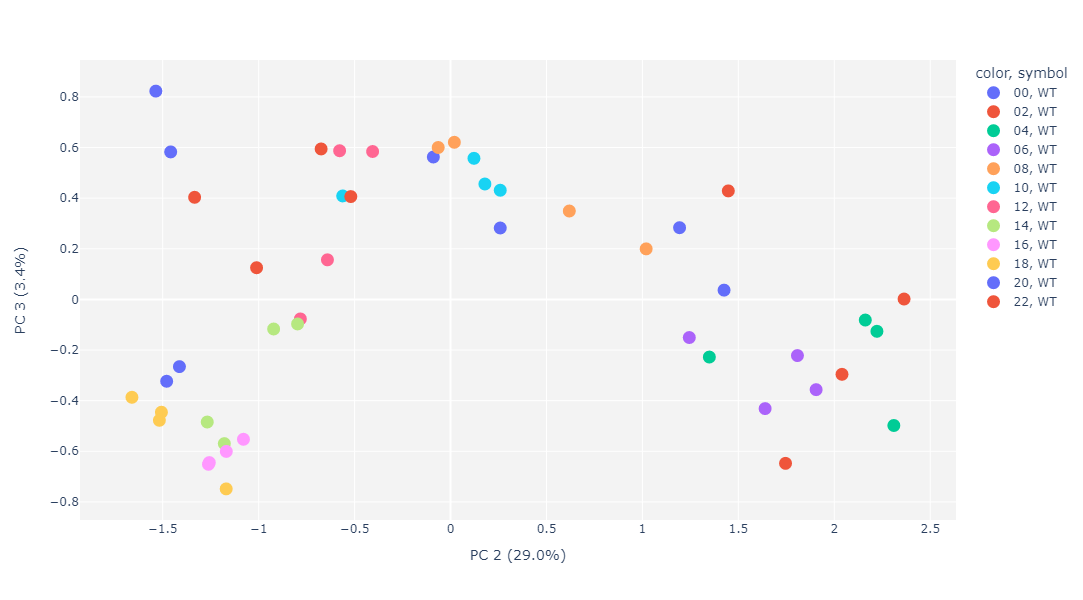

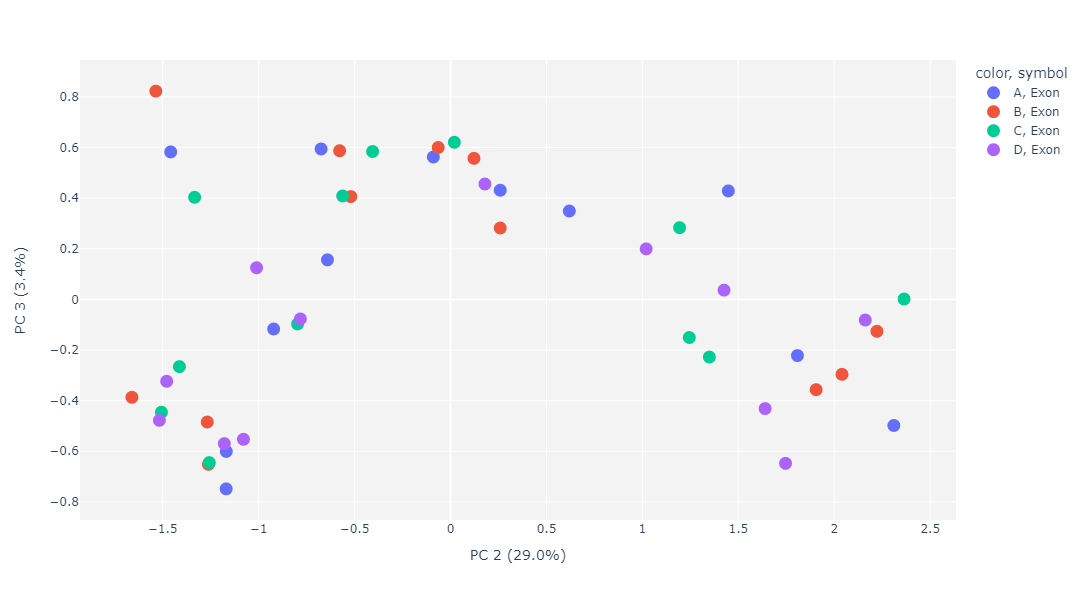

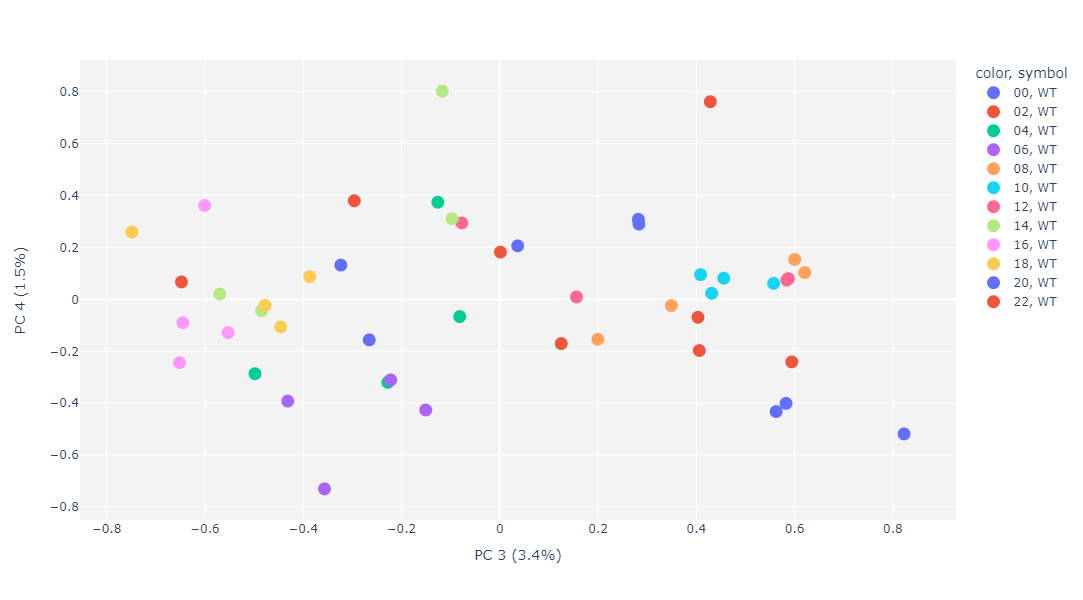

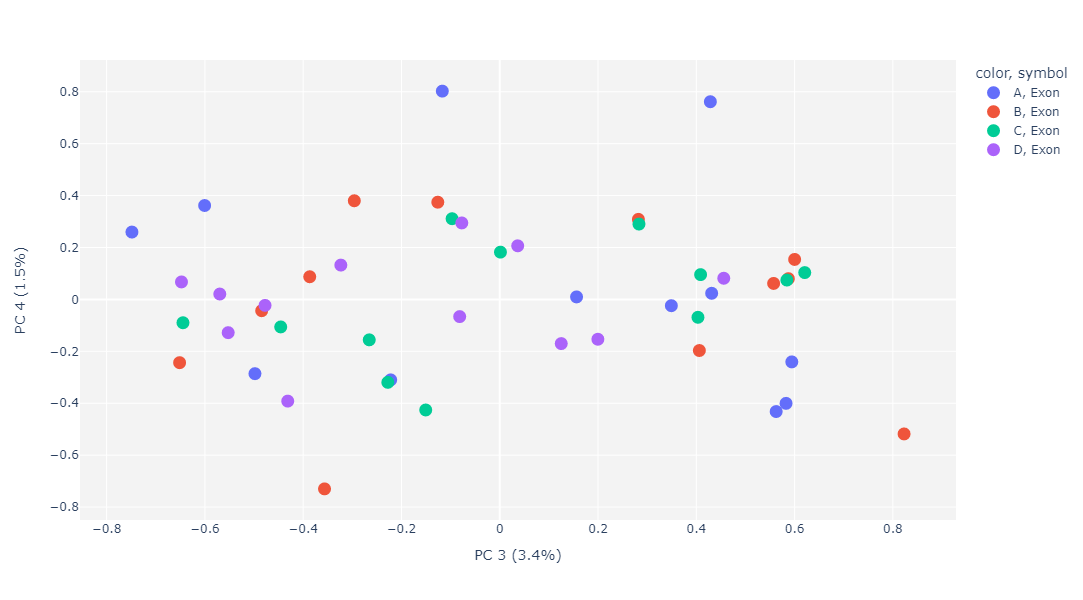

In [8]:
#Perform the PCA on exons
pca_exons = run_PCA(dat_exons, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

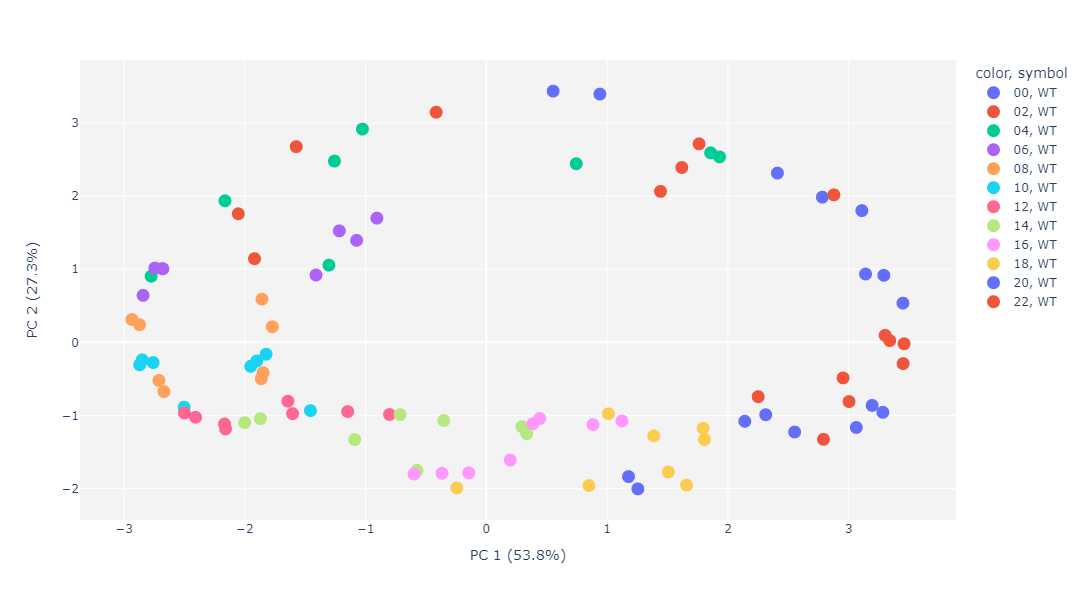

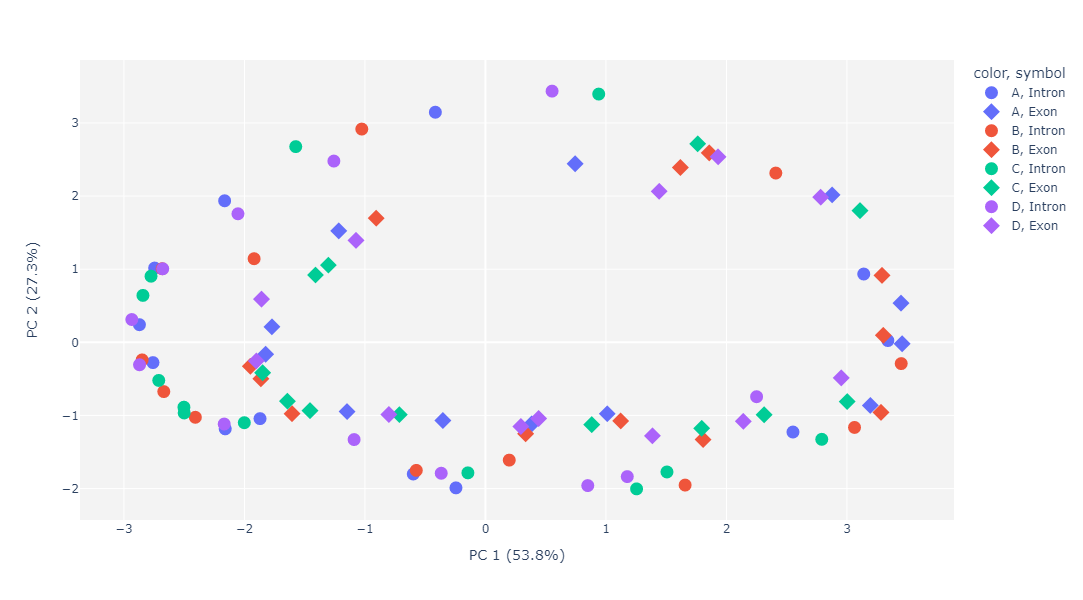

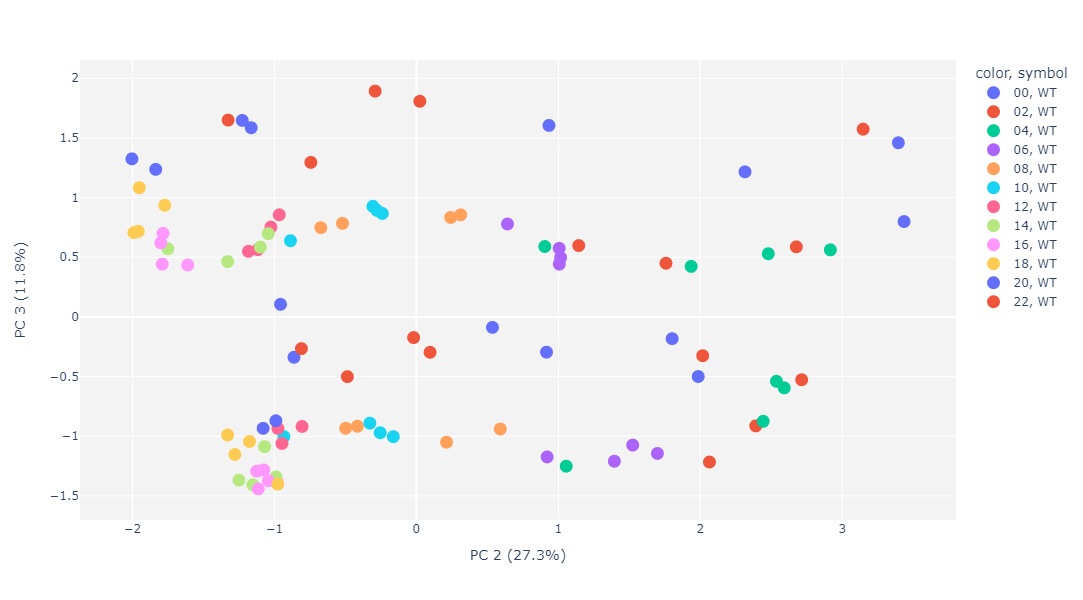

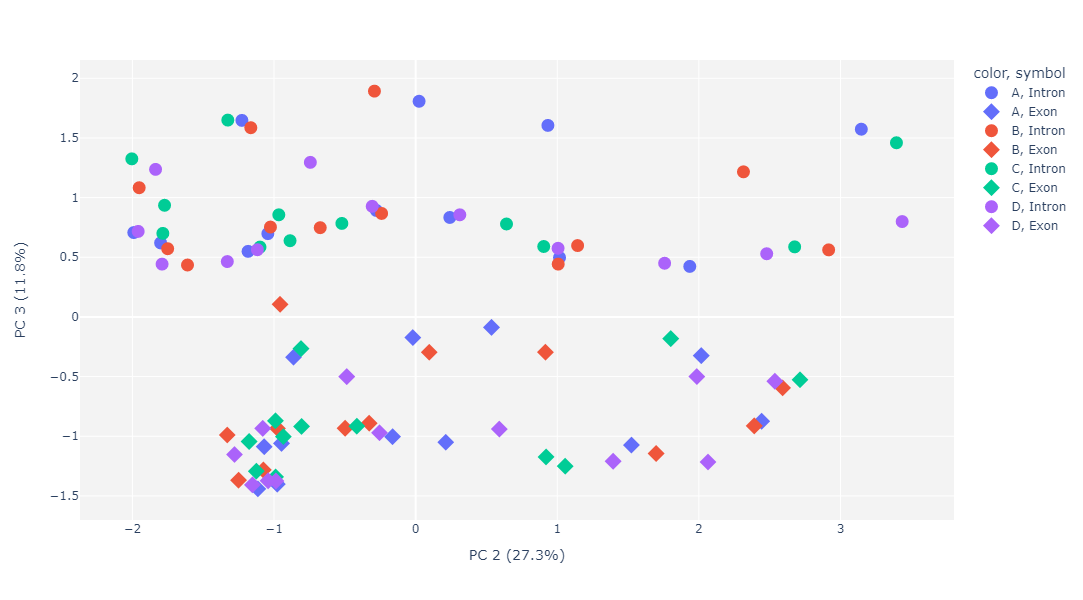

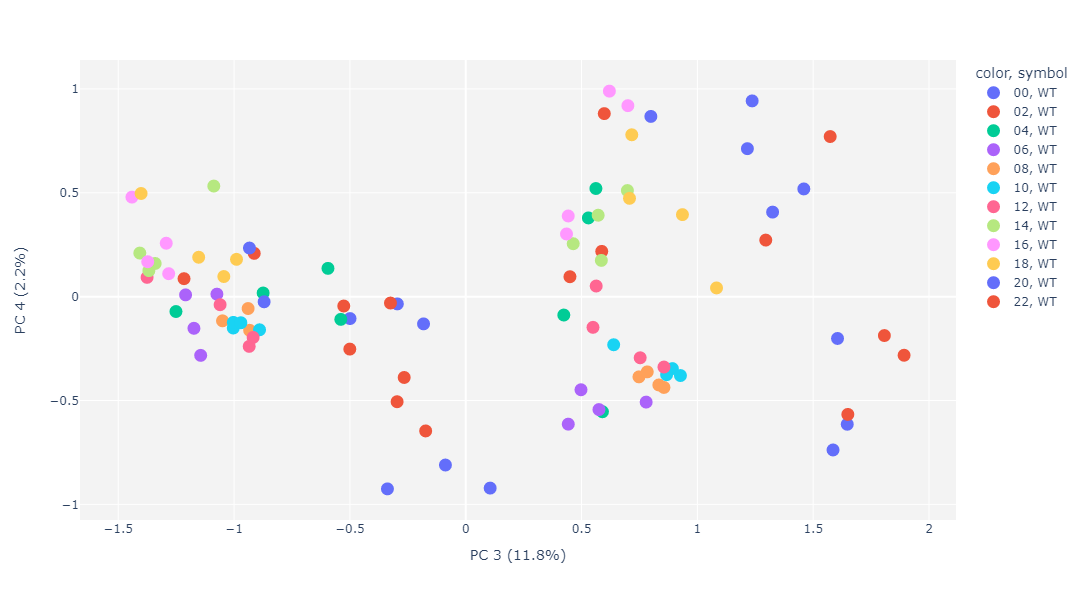

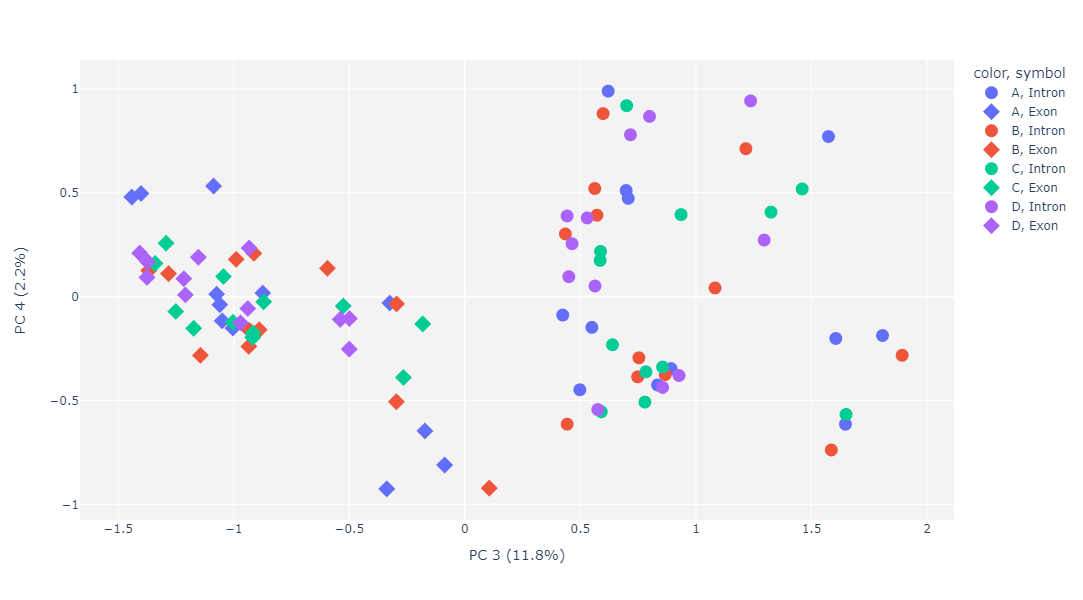

In [9]:
#Perform the PCA on exons + introns
pca_all = run_PCA(dat_tot, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_tot, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_tot, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

shape='feature', scale_d=True, log=False);
#%% md
### 1. PCA experiments

In both our exons-only and introns-only PCA experiments, some interesting and similar behaviours can be observed. 
The PC1 vs PC2 graphs in these two experiments show a rythmic behaviour of those two components with time, a rythmicity that is respected when looking at our PC1 vs PC2 graph in the case of replicates, which show the exact same behaviour.

More precisely, the PC1 vs PC2 values indeed seem to make a full circle from time 00 to time 22, indicating a rythmicity in the expression of our genes that follows a 24-hours period, indicating a gene expression pattern that follow the circadian cycle. As previously said, we can also see that our 4 replicates (A,B,C and D) all follow this "circle" behaviour.

In addition to this rythmicity, by looking at the PCA experiment when using both introns and exons, we can add that the exons and introns values for PC1 vs PC2 or PC3 vs PC4 differ. In the first case (PC1 vs PC2 in the case of replicates), while both exons and introns values follow the rythmicity seen above, exons values seem to be more "extreme"/large than the intron ones, whose circle behaviour seem to have a smaller radius. 
This difference is most blatant in the PC3 vs PC4 or even the PC2 vs PC3 graphs (again, the replicates ones), where there seem to be two clusters, one with the introns values and an other with exons values. 
C'est utile de dire ça / y'a quoi d'autre à dire?

#### Assess rhythmicity

In [10]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 
def return_amp_phase_pv(y, Ts, T, N):
    
    # we do the harmonic regression using a Fourier series
    t = np.linspace(0.0, N * Ts, N)
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)
    mu = 1 / N * x_fft[0].real
    
    #compute the residuals and statistics of the fit (pval)
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu

In [11]:
#Apply the function for all the genes at the intron or exon level and retrieve the amplitude, phase, mean and p-value.

Ts = 2.0 # sampling time 
T = 24 # period
N = 48 # number of samples

amp_intron = []
phase_intron = [] 
pv_intron = []
mu_intron = []

i_pos = all_dat.columns.get_level_values('feature').isin(['Intron'])

for i, row in all_dat.iterrows():
    [a, p, pv, mu] = return_amp_phase_pv(np.array(row)[i_pos], Ts, T, N)
    amp_intron.append(a)
    phase_intron.append(p)
    pv_intron.append(pv)
    mu_intron.append(mu)
    
amp_exon = []
phase_exon = [] 
pv_exon = []
mu_exon = []
e_pos = all_dat.columns.get_level_values('feature').isin(['Exon'])

for i, row in all_dat.iterrows():
    [a, p, pv, mu]=return_amp_phase_pv(np.array(row)[e_pos], Ts, T, N)
    amp_exon.append(a)
    phase_exon.append(p)
    pv_exon.append(pv)
    mu_exon.append(mu)

#convert the lists to numpy arrays
phase_intron=np.array(phase_intron)
amp_intron=np.array(amp_intron)
pv_intron=np.array(pv_intron)
mu_intron=np.array(mu_intron)

phase_exon=np.array(phase_exon)
amp_exon=np.array(amp_exon)
pv_exon=np.array(pv_exon)
mu_exon=np.array(mu_exon)

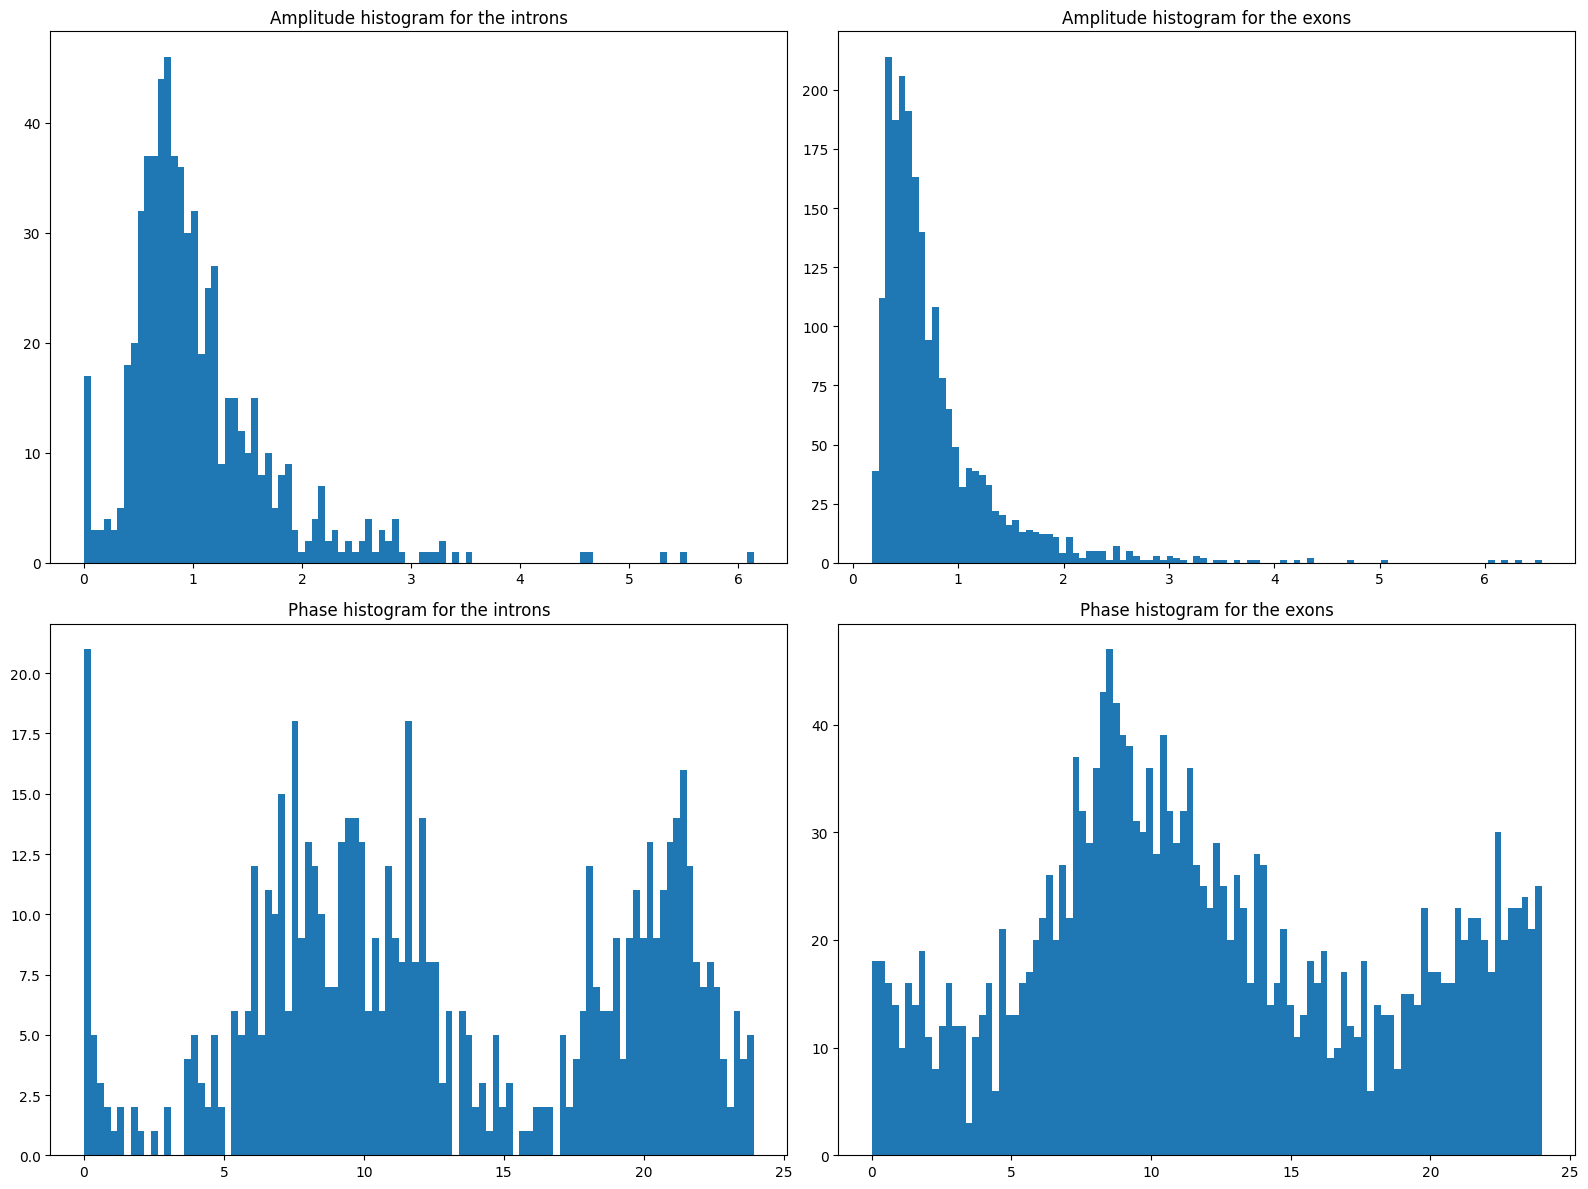

In [12]:
#Selecting only the amplitude/phases of introns & exons that show a p-value < 0.05.
# since we have multiple comparisons, we need to adapt our p-value by dividing it by the number of comparisons

good_introns_amp = amp_intron[pv_intron<(0.05/all_dat.shape[0])]
good_exons_amp = amp_exon[pv_exon<(0.05/all_dat.shape[0])]

good_introns_phase = phase_intron[pv_intron<(0.05/all_dat.shape[0])]
good_exons_phase = phase_exon[pv_exon<(0.05/all_dat.shape[0])]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (16,12))

ax1.hist(good_introns_amp,bins=100)
ax1.set_title('Amplitude histogram for the introns')   

ax2.hist(good_exons_amp,bins=100)
ax2.set_title('Amplitude histogram for the exons')

ax3.hist(good_introns_phase,bins=100);
ax3.set_title('Phase histogram for the introns')

ax4.hist(good_exons_phase,bins=100);
ax4.set_title('Phase histogram for the exons')

plt.tight_layout()
plt.show()

### 2. Phase and amplitude histograms

We can indeed observe a wave pattern of gene expression which is particularly noticeable in the phase histograms for the introns, where a peak around 7h~ and another one around 19~ hours can be observed (morning wave and evening wave).

### 3. Robustly rythmic genes

Je suis pas entièrement d'accord, voir ce que j'ai ecrit en dessous: (One can assume that the most robust genes regarding their rythmicity will be the ones where difference between maximum and minimum expression levels will be the highest. Indeed, the rythmicity of such genes is probably really crucial and the latter would then be pretty resistant to some changes in their expression.

In our case, we thus simply have to select the genes for which introns/exons amplitude is the highest. By looking at our histograms, we can try and fine the genes for which both introns and exons amplitude is, per say, >2, as it only concern a really small fraction of genes :)

To find the most robustly rythmic genes, we can use the function return_amp_phase_pv that does exactly that. The genes with the smallest p value will be the most significantly robust, we can thus select them. We just need to be careful, since some genes might have a low p-value but an amplitude of 0, indicating that they are constantly expressed. We thus want to make sure that we do not select these ones. 

In [13]:
# Find the most robust genes
# get the intron indices with low p value and not 0 amplitude
# since we have multiple comparisons, we need to adapt our p-value
index_good_introns = np.where(pv_intron < (0.05/all_dat.shape[0]))
index_good_amp_introns = np.where(amp_intron > 0.1)
index_good_introns = np.intersect1d(index_good_introns, index_good_amp_introns)
# get the exon indices with low p value and not 0 amplitude
index_good_exons = np.where(pv_exon < (0.05/all_dat.shape[0]))
index_good_amp_exons =  np.where(amp_exon > 0.1)
index_good_exons = np.intersect1d(index_good_exons, index_good_amp_exons)
# get indices of genes that are significant both at a pre-mRNA (introns) and mRNA (exons) levels
index_good_genes = np.intersect1d(index_good_introns, index_good_exons)
names_good_genes = all_dat.index[index_good_genes].values
print("We found " + str(len(names_good_genes)) + " most rythmically robus genes. They are:")
print(names_good_genes)

We found 493 most rythmically robus genes. They are:
['Narf' 'Itga5' 'Pxmp4' 'Lgals9' 'Dpp9' 'Kpnb1' 'Ugp2' 'Sipa1l2' 'Ccne1'
 'Ppard' 'Ggct' 'Adprh' 'Grk5' 'Btbd2' 'Inmt' 'Klc4' 'Crot' 'Insig2' 'Hlf'
 'Angptl2' 'Pnpla6' 'Wwox' 'Slc1a2' 'Ripk4' 'Ubqln1' 'Por' 'Shpk' 'Nat15'
 'Aamp' 'Elovl1' 'Slc5a6' 'Gmnn' 'Abhd8' 'Fgfrl1' 'Slc16a12' 'Fpgs'
 'Pla2g12b' 'Slc38a3' 'Vac14' 'Gfod2' 'St3gal1' 'Mrps25' 'Camta1'
 'Fam120b' 'Slc25a13' 'Clpx' 'Amdhd1' 'Celsr1' 'Lonrf3' 'Ppfibp1' 'Lamp2'
 'Psmd11' 'Igfbp4' 'Ints2' 'Ypel2' 'Ndel1' 'Map2k3' 'Gle1' 'Syne1' 'Cd164'
 'Traf3ip2' 'Rfx4' 'Cry1' 'Timp3' 'Pah' 'Aifm2' 'Slc16a7' 'Ddit4' 'Ddc'
 'Mknk2' 'Adarb1' 'Sumo3' 'Pfkl' 'Cpeb4' 'Nampt' 'Arsg' 'Map2k6' 'Rnf144a'
 'Polg2' 'Slc9a3r1' 'Nr1d1' 'Per1' 'Clmn' 'Glrx5' 'Hsp90aa1' 'Eci2' 'Glrx'
 'Acot12' 'Mtx3' 'Dhfr' 'Nr1d2' 'Nid2' 'Anxa7' 'Anxa11' 'Pnp' 'Spryd7'
 'Tars' 'Amacr' 'Rai14' 'Mtss1' 'Ppara' 'Ttll8' 'Tef' 'Enpp2' 'Slc38a4'
 'Cldn1' 'Mgrn1' 'Tymp' 'Bfar' 'Tfrc' 'Tmem41a' 'Rcan1' 'Adcy6' 'Soat2'
 'Cal

We see some core clock genes such as: Arntl, Cry2, Per1, Per2

Jsp s'il faut plus developer ou trouver d'autres trucs ?

### 4. EnrichR analysis

In [14]:
#We want to split the robustaly rythmic genes selected previously into genes expressed during the day and genes expressed during the night
# -> this can be done using the phase
#Since we want to see biological function, we are mostly interested about the mRNA expression (i.e the exons)
good_phase_exon = phase_exon[index_good_genes]
# we assume day time is from 7am to 8pm
day_genes = names_good_genes[(good_phase_exon > 7) & (good_phase_exon < 20)]
night_genes = names_good_genes[(good_phase_exon < 7) | (good_phase_exon > 20 )]
print("We have " + str(day_genes.size) + " day genes")
print("We have " + str(night_genes.size) + " night genes")

We have 304 day genes
We have 189 night genes


In [15]:
gene_sets = ['GO_Biological_Process_2021']
enr_process_day = gp.enrichr(gene_list=list(day_genes),
           gene_sets=gene_sets,
           organism='mouse',
           outdir=None)

In [16]:
mouse = gp.get_library_name(organism='Mouse')

In [17]:
#Analysis for the day genes
enr = gp.enrichr(gene_list=list(day_genes),
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=list(day_genes),
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0                    vascular transport (GO:0010232)   11/84  5.791516e-08   
1  transport across blood-brain barrier (GO:0150104)   11/86  7.425358e-08   
2                 cholesterol transport (GO:0030301)    8/51  9.380351e-07   
3  entrainment of circadian clock by photoperiod ...    6/27  2.655263e-06   
4                        photoperiodism (GO:0009648)    6/28  3.336473e-06   
5  negative regulation of intracellular signal tr...  13/198  1.121583e-05   
6               cholesterol homeostasis (GO:0042632)    8/71  1.204739e-05   
7                    sterol homeostasis (GO:0055092)    8/72  1.337647e-05   
8                    cholesterol efflux (GO:0033344)    5/24  2.632171e-05   
9        phospholipid catabolic process (GO:0009395)    5/24  2.632171e-05   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000074            0                     0   10.091776   
1          0.000074            0                     0    9.821661   
2          0.000625            0                     0   12.352608   
3          0.001328            0                     0   18.863854   
4          0.001335            0                     0   18.005491   
5          0.003344            0                     0    4.711489   
6          0.003344            0                     0    8.422565   
7          0.003344            0                     0    8.290541   
8          0.005264            0                     0   17.318254   
9          0.005264            0                     0   17.318254   

   Combined Score                                              Genes  
0      168.172250  SLC5A6;SLC9A3R1;ABCC2;TFRC;SLC6A9;SLC1A2;SLC16...  
1      161.230224  SLC5A6;SLC9A3R1;ABCC2;TFRC;SLC6A9;SLC1A2;SLC16...  
2      171.447762     ABCG8;ABCG5;STARD5;NPC1;OSBPL5;SOAT2;LIPG;TSKU  
3      242.192398                      PER2;PER1;PER3;USP2;CRY2;CRY1  
4      227.059979                      PER2;PER1;PER3;USP2;CRY2;CRY1  
5       53.702417  MAP2K3;MGRN1;UBR2;NR1D1;MAPK14;PER1;SLC9A3R1;D...  
6       95.399553       ABCG8;ABCG5;DGAT2;NPC1;SOAT2;LIPG;NR1D1;TSKU  
7       93.036556       ABCG8;ABCG5;DGAT2;NPC1;SOAT2;LIPG;NR1D1;TSKU  
8      182.623006                        ABCG8;ABCG5;NPC1;SOAT2;TSKU  
9      182.623006                      LIPG;GDE1;ENPP2;PNPLA6;GPCPD1

Gene_set                                               Term   Overlap  \
0  ChEA_2022                  RXR 22158963 ChIP-Seq LIVER Mouse  117/1546   
1  ChEA_2022                  LXR 22158963 ChIP-Seq LIVER Mouse  110/1578   
2  ChEA_2022                PPARA 22158963 ChIP-Seq LIVER Mouse   86/1552   
3  ChEA_2022                 CLOCK 20551151 ChIP-Seq 293T Human    41/382   
4  ChEA_2022                FOXA2 19822575 ChIP-Seq HepG2 Human   86/2553   
5  ChEA_2022                ESR1 17901129 ChIP-ChIP LIVER Mouse    27/354   
6  ChEA_2022               PPARG 20887899 ChIP-Seq 3T3-L1 Mouse   87/2774   
7  ChEA_2022  STAT5A 24692510 ChIP-Seq Epithelium Mouse Mammary   68/1977   
8  ChEA_2022  NR3C1 27076634 ChIP-Seq BEAS2B Human Lung Infl...   91/3084   
9  ChEA_2022      NR3C2 34362910 ChIP-Seq WistarRat Hippocampus   56/1496   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  5.365655e-52      3.933025e-49            0                     0   
1  5.950229e-45      2.180759e-42            0                     0   
2  5.366218e-27      1.311146e-24            0                     0   
3  4.873329e-23      8.930375e-21            0                     0   
4  3.256674e-13      4.774284e-11            0                     0   
5  6.664222e-12      8.141458e-10            0                     0   
6  1.169831e-11      1.224980e-09            0                     0   
7  8.492840e-11      7.563546e-09            0                     0   
8  9.286755e-11      7.563546e-09            0                     0   
9  2.610259e-10      1.913320e-08            0                     0   

   Odds Ratio  Combined Score  \
0    7.997961      944.194480   
1    7.040507      716.955217   
2    4.905628      296.739869   
3    8.848444      454.594825   
4    2.755072       79.216295   
5    5.773557      148.578257   
6    2.537877       63.882376   
7    2.684687       62.255781   
8    2.384238       55.075526   
9    2.862724       63.170018   

                                               Genes  
0  NARF;AQP9;GMNN;GDE1;HJURP;RORC;TSKU;RAB43;BAIA...  
1  GDA;AQP9;WIPF3;HJURP;RORC;ADARB1;TSKU;RAB43;BA...  
2  KCNK5;NARF;HSP90AB1;HJURP;RORC;SLC2A2;N4BP2L1;...  
3  PDXK;HLF;HSP90AB1;TFRC;BRI3;AK2;RORC;ATP2A2;TR...  
4  NARF;HSP90AB1;WIPF3;SLC2A2;SERPINA6;FGF1;TSKU;...  
5  RORC;SERPINA6;GNS;MARVELD1;P2RY2;MKNK2;SLC38A3...  
6  NARF;TFRC;GDA;N4BP2L1;SIPA1L2;FGF1;SYDE2;NAMPT...  
7  KCNK5;HSP90AB1;GDA;AQP9;RORC;SIPA1L2;FGF1;TSKU...  
8  AQP9;ECI2;GMNN;WIPF3;ATP2A2;SERPINA6;SIPA1L2;F...  
9  MAST3;WIPF3;ATP2A2;ADARB1;FHAD1;NAMPT;TIMP3;UP...

In [18]:
#Analysis for the night genes
enr = gp.enrichr(gene_list=list(night_genes),
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=list(night_genes),
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   
8  GO_Biological_Process_2021   
9  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0           apical protein localization (GO:0045176)    3/10  0.000095   
1  organic hydroxy compound biosynthetic process ...    5/50  0.000107   
2        sphingolipid metabolic process (GO:0006665)   7/116  0.000118   
3  ubiquitin-dependent protein catabolic process ...  12/354  0.000145   
4  monocarboxylic acid biosynthetic process (GO:0...    5/63  0.000322   
5      ganglioside biosynthetic process (GO:0001574)    3/15  0.000348   
6          steroid biosynthetic process (GO:0006694)    5/65  0.000373   
7            cell junction organization (GO:0034330)    5/72  0.000599   
8         ganglioside metabolic process (GO:0001573)    3/20  0.000841   
9  negative regulation of sphingolipid biosynthet...     2/5  0.000872   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.053922            0                     0   45.631336   
1          0.053922            0                     0   11.935990   
2          0.053922            0                     0    6.952011   
3          0.053922            0                     0    3.859451   
4          0.079390            0                     0    9.254591   
5          0.079390            0                     0   26.611559   
6          0.079390            0                     0    8.945199   
7          0.107808            0                     0    8.007787   
8          0.107808            0                     0   18.779886   
9          0.107808            0                     0   70.616756   

   Combined Score                                              Genes  
0      422.660489                                   INSC;CELSR1;ACTB  
1      109.097935                    HSD3B7;AMACR;INSIG2;PMVK;ABCB11  
2       62.884694  ABCA2;ELOVL1;PRKD3;ELOVL3;ORMDL3;ST6GALNAC3;ST...  
3       34.119299  RNF144A;RNF144B;PSMD11;UBXN1;RNF125;TRIM2;UBE2...  
4       74.408418                     HSD3B7;LIPC;AMACR;ABCB11;ACMSD  
5      211.949228                      ST6GALNAC3;ST3GAL1;ST6GALNAC6  
6       70.613384                    HSD3B7;AMACR;INSIG2;PMVK;ABCB11  
7       59.419307                     PPFIBP1;CLDN1;ACTB;FERMT2;TJP3  
8      132.977594                        ABCA2;ST6GALNAC3;ST6GALNAC6  
9      497.489501                                       ABCA2;ORMDL3

Gene_set                                               Term  Overlap  \
0  ChEA_2022                  LXR 22158963 ChIP-Seq LIVER Mouse  61/1578   
1  ChEA_2022                PPARA 22158963 ChIP-Seq LIVER Mouse  53/1552   
2  ChEA_2022                  RXR 22158963 ChIP-Seq LIVER Mouse  52/1546   
3  ChEA_2022                 CLOCK 20551151 ChIP-Seq 293T Human   18/382   
4  ChEA_2022                ESR1 17901129 ChIP-ChIP LIVER Mouse   16/354   
5  ChEA_2022                 EGR1 23403033 ChIP-Seq LIVER Mouse   19/516   
6  ChEA_2022              MITF 21258399 ChIP-Seq MELANOMA Human  72/4614   
7  ChEA_2022                  BRD4 25478319 ChIP-Seq HGPS Human  36/1770   
8  ChEA_2022                  SMC1 22415368 ChIP-Seq MEFs Mouse  33/1583   
9  ChEA_2022  CTCF 31629814 ChIP-Seq Hepatocytes Mouse Tyros...  52/3086   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  2.156463e-22      1.587157e-19            0                     0   
1  6.082618e-17      2.238403e-14            0                     0   
2  2.462037e-16      6.040198e-14            0                     0   
3  2.512648e-08      4.623273e-06            0                     0   
4  2.727981e-07      4.015588e-05            0                     0   
5  4.762037e-07      5.841432e-05            0                     0   
6  2.296580e-06      2.414690e-04            0                     0   
7  8.594853e-06      7.907264e-04            0                     0   
8  1.321990e-05      1.038069e-03            0                     0   
9  1.410420e-05      1.038069e-03            0                     0   

   Odds Ratio  Combined Score  \
0    5.747023      286.709813   
1    4.760703      177.757571   
2    4.653573      167.251144   
3    5.623771       98.412300   
4    5.328317       80.535026   
5    4.343307       63.227344   
6    2.068760       26.860964   
7    2.452948       28.612036   
8    2.492196       27.996800   
9    2.098850       23.442141   

                                               Genes  
0  SLC44A1;THRA;LEAP2;SDR9C7;CROT;FBXO21;ADRA1B;C...  
1  AHCTF1;CDKN1A;TRAF3IP2;LEAP2;AQP8;SDR9C7;FBXO2...  
2  AHCTF1;CHIC1;LEAP2;SDR9C7;FBXO21;CLDN1;ACTB;FL...  
3  CDKN1A;SLC16A1;PSMD11;CHKA;FBXO21;NPAS2;ACTB;C...  
4  DDC;INSIG2;LEAP2;FGG;ADRA1B;ABCB11;ACTB;GJB1;L...  
5  AHCTF1;DDC;MREG;DESI2;INSIG2;LEAP2;FGG;SLC30A1...  
6  CDKN1A;CHIC1;SLC44A1;TRAF3IP2;THRA;LEAP2;LOXL4...  
7  AHCTF1;LEAP2;ASAP2;CELSR1;SLC4A4;MED12L;LIPC;G...  
8  CDKN1A;PSMD11;TRAF3IP2;AQP8;NEDD4L;ASAP2;ADRA1...  
9  SLC44A1;THRA;LEAP2;LGALSL;ADRA1B;CLDN1;TRIM2;F...

### EnrichR analysis discussion

For biological processes, we see a big difference between night and day. Biological processes linked with genes expressed rythmically during the day are, as expected, entrainment of circadian clock and photoperiodism that are linked to the circadian cycle. Also, we see quite a lot of processes related to metabolism or transport. This makes sense since these pathways will be more required when the mouse is active, i.e in daytime. During the night, we see mostly biosynthesis pathways. During the night the mouse is not active and thus can use its energy for this kind of processes.

For the transcriptional activity, we don't see a lot of difference between day and night. The most significant trnascription (i.e. the first ones in the table) are similar. Unsurprisingly, we see CLOCK, a transcription factor involved in circadian rythm regulation, appear in both tables. It makes sense that this TF has a rythmic behaviour. 

Je sais pas trop quoi dire d'autre...


### Question 2
1. Study the phase relationship between the pre-mRNA and mRNA for genes that you selected to be rhythmic at both the pre-mRNA and mRNA levels. Use cutoffs that give you several hundred genes.
2. Show representative profiles of genes with short or large delays.
3. Analyze the phase difference in function of the ratio of relative amplitudes of the mRNA and pre-mRNA. What is the expected behavior for genes with constant degradation (see course)?  
4. For genes with a positive difference bewteen 0h and 6h, describe whether these follow the prediction.
5. Identify few outliers and discuss them. Can you say something about how these might be regulated?

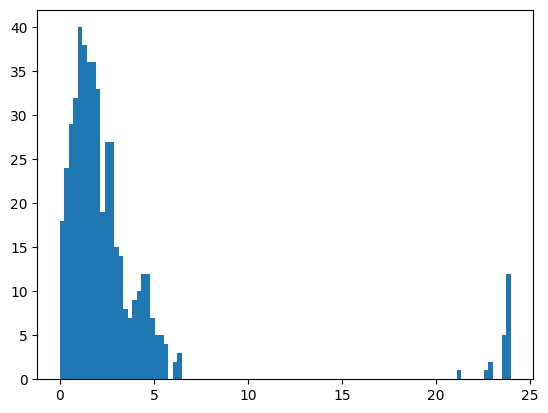

The median of the phase difference for our selected genes is: 1.8622241558704182


In [19]:
# we have 493 genes (selected in previous questions) -> cutoff corresponds to what is asked
good_phase_exon = phase_exon[index_good_genes]
good_phase_intron = phase_intron[index_good_genes]
good_phase_difference = good_phase_exon - good_phase_intron
# a negative phase difference is the same as phase_diff + period (here we have a period of 24h)
good_phase_difference[good_phase_difference<0] += 24
plt.hist(good_phase_difference, bins=100)
plt.show()
print("The median of the phase difference for our selected genes is: " + str(np.median(good_phase_difference)))

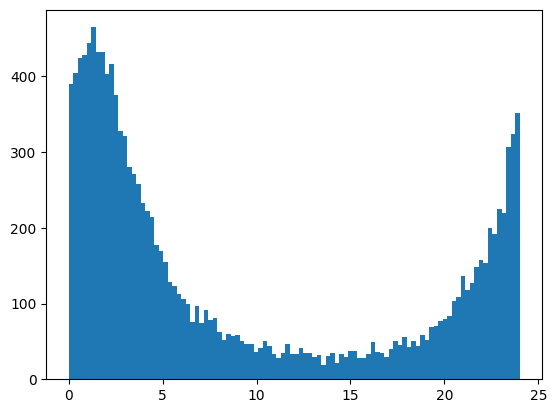

The median of the phase difference for all genes in the data set is: 4.552237898030098


In [20]:
phase_diff = phase_exon - phase_intron
phase_diff[phase_diff<0] += 24
plt.hist(phase_diff, bins=100)
plt.show()
print("The median of the phase difference for all genes in the data set is: " + str(np.median(phase_diff)))

### Question 2.1

We see that, in general, the phase difference is relatively low. The phase difference indicates the time difference between pre-mRNA and mRNA. A small phase difference means that pre-mRNA is processed relatively quickly into mRNA. Here we see that the median phase difference of our selected genes is 1.86 hour comparing to 4.55 hours when we take all the genes in our dataset. We can thus conclude that highly rythmic genes have generally a quicker pre-mRNA processing than other genes.

### Question 2.2

In [21]:
# get a gene with a short delay, i.e less than 15 minutes
index_short_delay_gene = index_good_genes[good_phase_difference<0.25][-1]
short_delay_gene = all_dat.iloc[index_short_delay_gene]
idx = [short_delay_gene.index.values[i][2] for i in range(len(short_delay_gene))]
idx_intron = np.array(idx) == 'Intron'
idx_exon = np.array(idx) == 'Exon'

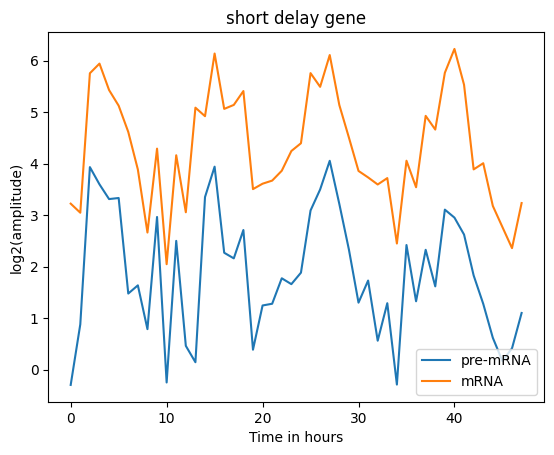

In [63]:
plt.plot(np.arange(24*2), short_delay_gene.values[idx_intron])
plt.plot(np.arange(24*2), short_delay_gene.values[idx_exon])
plt.legend(["pre-mRNA", "mRNA"])
plt.xlabel('Time in hours')
plt.ylabel('log2(amplitude)')
plt.title("short delay gene")
plt.show()

In [64]:
# get a gene with a long delay, i.e. more than 10 hours
index_long_delay_gene = index_good_genes[good_phase_difference>10][-1]
long_delay_gene = all_dat.iloc[index_long_delay_gene]
idx_ldg = [long_delay_gene.index.values[i][2] for i in range(len(long_delay_gene))]
idx_intron_ldg = np.array(idx_ldg) == 'Intron'
idx_exon_ldg = np.array(idx_ldg) == 'Exon'

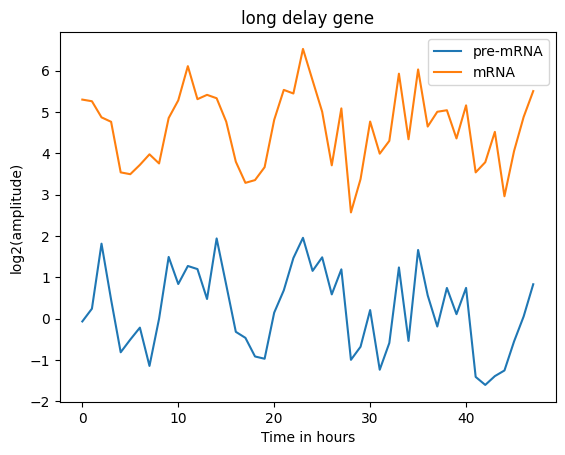

In [65]:
plt.plot(np.arange(24*2), long_delay_gene.values[idx_intron_ldg])
plt.plot(np.arange(24*2), long_delay_gene.values[idx_exon_ldg])
plt.legend(["pre-mRNA", "mRNA"])
plt.xlabel('Time in hours')
plt.ylabel('log2(amplitude)')
plt.title("long delay gene")
plt.show()

### Question 2.3



In [22]:
#Note that because you fitted the log2 data, the relative amplitudes take the form
relamp_exon = 2**amp_exon[index_good_genes] - 2**(-amp_exon[index_good_genes])
relamp_intron = 2**amp_intron[index_good_genes]- 2**(-amp_intron[index_good_genes])
relamp_ratio = relamp_exon/relamp_intron
good_phase_difference_updated = good_phase_difference[relamp_ratio<1]
relamp_ratio_updated = relamp_ratio[relamp_ratio<1]

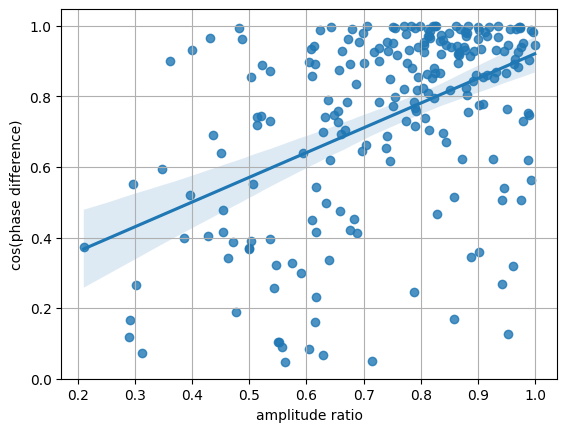

In [23]:
# convert phase in radiant
phase_radiant = 2*np.pi*good_phase_difference_updated/24
sns.regplot(x = relamp_ratio_updated, y = np.abs(np.cos(phase_radiant)))
plt.ylabel("cos(phase difference)")
plt.xlabel("amplitude ratio")
plt.grid()
plt.show()

In the case of constant degradation, we should see that the amplitude ratio is equal to the cosinus of the phase difference. If we plot the amplitude ratio with regard to the cosinus of the phase difference, we should thus observe a linear relationship with a sl. In our plot, we do not see a clear linear relationship when looking at the scatter plot. However, we still see a linear regression that fits relatively well the data and that the slope is approximately 1. Probably that there are a few outliers that prevent from having a perfect linear relationship.

### Question 2.4

In [24]:
phase_diff = phase_exon[index_good_genes]-phase_intron[index_good_genes]
phase_diff = phase_diff[relamp_ratio<1]
phase_diff_06 = phase_diff[(phase_diff>=0) & (phase_diff<=6)]
phase_radiant = 2*np.pi*phase_diff_06/24
relamp_ratio_06 = relamp_ratio_updated[(phase_diff>=0) & (phase_diff<=6)]

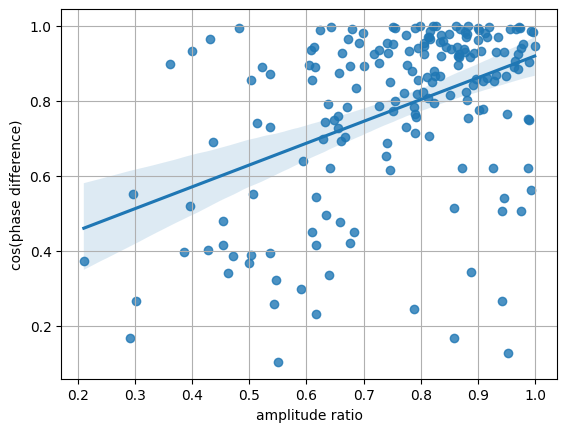

In [25]:
sns.regplot(x = relamp_ratio_06, y = np.abs(np.cos(phase_radiant)))
plt.ylabel("cos(phase difference)")
plt.xlabel("amplitude ratio")
plt.grid()
plt.show()

Again, we can make the same observations than in the question 2.3. There is no clear linear relationship but it might be due to some genes behaving differently and preventing the model from fitting perfectly with a slope of 1. However, it does seem like there are not as many outliers.

### Question 2.5

In [26]:
# get all genes name
genes_names = all_dat.index[index_good_genes].values
genes_names = genes_names[relamp_ratio<1]
genes_names = genes_names[(phase_diff>=0) & (phase_diff<=6)]
# select outliers
outlier_genes = genes_names[(relamp_ratio_06>0.8) & (np.abs(np.cos(phase_radiant))<0.4)]
print("The outliers are:") 
print(outlier_genes)

The outliers are:
['Ugp2' 'Sumo3' 'Anxa7' 'St6galnac6']


The outliers selected have a high amplitude ratio and a low cosinus of phase difference. Since they do not fit the expected linear model, they probably do not have a constant degradation rate. In the list we see Sumo3, a protein used for post-translational modifications to promote different processes such as, nuclear transport or apoptosis. It makes sense that the degradation of this protein is regulated in a complexe way since can regulate many other cellular processes. The mRNA degradation rate might be influenced by other proteins to have more or less Sumo3 in cells needing it. For instance degradation might be downregulated by other proteins promoting apoptosis in cells that need to undergo apoptosis.